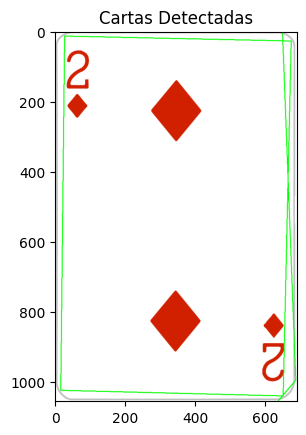

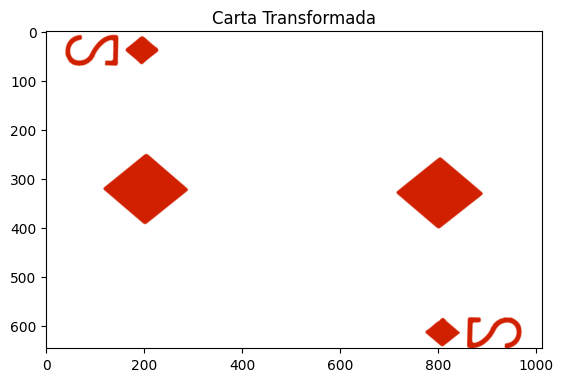

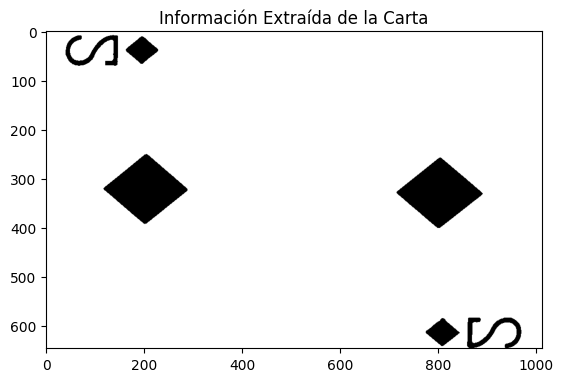

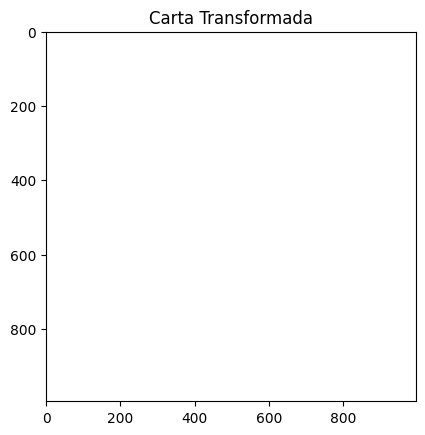

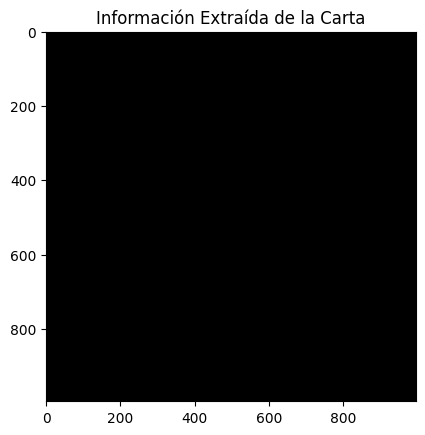

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar filtro gaussiano para reducir ruido
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Mejorar el contraste con una ecualización de histograma
    enhanced = cv2.equalizeHist(blurred)
    return enhanced

# Función para detectar los bordes utilizando el algoritmo de Canny
def detect_edges(image):
    # Detectar bordes con Canny
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        # Aproximación de los contornos
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Filtramos solo los contornos con 4 vértices
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal
def transform_perspective(image, contour):
    # Definir puntos de la perspectiva inicial y final (debe ser ajustado según el contorno)
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])
    width = max(np.linalg.norm(pts1[0] - pts1[1]), np.linalg.norm(pts1[2] - pts1[3]))
    height = max(np.linalg.norm(pts1[0] - pts1[3]), np.linalg.norm(pts1[1] - pts1[2]))
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    
    # Matriz de transformación de perspectiva
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
    # Realizar la transformación de perspectiva
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    
    return warped

# Función para extraer información de la carta (valor y palo)
def extract_card_info(card_image):
    # Convertir a escala de grises y binarizar
    gray = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    _, binarized = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Aquí se puede realizar un análisis de plantillas, por ejemplo, comparar con plantillas de los números y palos.
    # Se puede usar una red neuronal para reconocimiento de caracteres o buscar plantillas para cada número y palo.
    # Este paso debe ser personalizado con tus propias plantillas o red de reconocimiento.
    
    return binarized

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/2D.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    
    # Extraer la información de la carta
    card_info = extract_card_info(card_image)
    
    # Mostrar la información extraída
    plt.imshow(card_info, cmap='gray')
    plt.title("Información Extraída de la Carta")
    plt.show()
